# NFL 4th Down Analytics

Project designed to provide insights for NFL coaches in order to make a better decision on Fourth Down

In [1]:
#import packages
import pandas as pd
import numpy
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import statsmodels.formula.api as smf
from sklearn.cluster import KMeans
from sklearn import model_selection
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

## Gather/Create DF

In [2]:
#import data
f = pd.read_csv("C:\Users\joshk\Documents\NFLAnalytics\NFL2009-16.csv", low_memory=False)
f.shape

(362447, 100)

In [3]:
[x for x in f]

['Date',
 'GameID',
 'Drive',
 'qtr',
 'down',
 'time',
 'TimeUnder',
 'TimeSecs',
 'PlayTimeDiff',
 'SideofField',
 'yrdln',
 'yrdline100',
 'ydstogo',
 'ydsnet',
 'GoalToGo',
 'FirstDown',
 'posteam',
 'DefensiveTeam',
 'desc',
 'PlayAttempted',
 'Yards.Gained',
 'sp',
 'Touchdown',
 'ExPointResult',
 'TwoPointConv',
 'DefTwoPoint',
 'Safety',
 'Onsidekick',
 'PuntResult',
 'PlayType',
 'Passer',
 'Passer_ID',
 'PassAttempt',
 'PassOutcome',
 'PassLength',
 'AirYards',
 'YardsAfterCatch',
 'QBHit',
 'PassLocation',
 'InterceptionThrown',
 'Interceptor',
 'Rusher',
 'Rusher_ID',
 'RushAttempt',
 'RunLocation',
 'RunGap',
 'Receiver',
 'Receiver_ID',
 'Reception',
 'ReturnResult',
 'Returner',
 'BlockingPlayer',
 'Tackler1',
 'Tackler2',
 'FieldGoalResult',
 'FieldGoalDistance',
 'Fumble',
 'RecFumbTeam',
 'RecFumbPlayer',
 'Sack',
 'Challenge.Replay',
 'ChalReplayResult',
 'Accepted.Penalty',
 'PenalizedTeam',
 'PenaltyType',
 'PenalizedPlayer',
 'Penalty.Yards',
 'PosTeamScore',
 'De

In [4]:
#find all play types
plays = []
for x in f['PlayType']:
    if plays.count(x) == 0:
        plays.append(x)  
print plays

['Kickoff', 'Pass', 'Run', 'Punt', 'Sack', 'Field Goal', 'No Play', 'Quarter End', 'Two Minute Warning', 'Timeout', 'Extra Point', 'QB Kneel', 'End of Game', 'Spike', 'Half End']


In [5]:
#assign ids to play types
playID = {plays[x]: x for x in range(len(plays))}
print playID

{'Quarter End': 7, 'Half End': 14, 'QB Kneel': 11, 'Run': 2, 'Spike': 13, 'Extra Point': 10, 'Sack': 4, 'Field Goal': 5, 'Punt': 3, 'Kickoff': 0, 'Timeout': 9, 'Pass': 1, 'Two Minute Warning': 8, 'End of Game': 12, 'No Play': 6}


In [6]:
#convert play type str to num
play_type = []
for x in f['PlayType']:
    play_type.append(playID[x])

In [7]:
#create dummy if first completed
first = []
for x in range(f.shape[0]):
    if f['ydstogo'][x] <= f['Yards.Gained'][x]:
        first.append(1)
    else:
        first.append(0)

In [8]:
#create array for down
down = []
for x in f['down']:
    if x == 1:
        down.append(1)
    elif x == 2:
        down.append(2)
    elif x == 3:
        down.append(3)
    elif x == 4:
        down.append(4)
    else:
        down.append(0)

In [9]:
#find net yards gained and net plays up to each play
net_yd = []
net_ply = []
game = 0

def append_values(a, b):
    net_yd.append(a)
    net_ply.append(b)
    
for r in range(f.shape[0]):
    if f['GameID'][r] != game:
        team1 = {
            'id': 0,
            'net_yd': 0,
            'net_ply' :0
        }
        team2 = {
            'net_yd': 0,
            'net_ply' :0
        }
        game = f['GameID'][r]
        team1['id'] = f['posteam'][r]
    if f['PlayType'][r] in ["Pass", "Run", "Sack"]:
        if team1['id'] == f['posteam'][r]:
            team1['net_yd'] += f['Yards.Gained'][r]
            team1['net_ply'] += 1
            append_values(team1['net_yd'], team1['net_ply'])
        else:
            team2['net_yd'] += f['Yards.Gained'][r]
            team2['net_ply'] += 1
            append_values(team2['net_yd'], team2['net_ply'])
    else:
        append_values(0, 0)
    

In [10]:
#Find average yards gained in that game
avg_yd = []
for x in range(len(net_yd)):
    if net_ply[x] > 0:
        avg = net_yd[x]/net_ply[x]
        avg_yd.append(avg)
    else:
        avg_yd.append(0)

In [11]:
#% of First downs completed
completed = 0
total = 0
for x in range(f.shape[0]):
    if f['down'][x] == 4 or f['down'][x] == 3:
        total += 1
        if first[x] == 1:
            completed += 1
print "First downs completed: " + str(float(completed)/float(total) * 100) + "%"

First downs completed: 30.9587760029%


In [12]:
#New Dataframe
df = {
    'down': pd.Series(down),
    'yd_ln': f['yrdline100'],
    'to_go': f['ydstogo'],
    'play_type': pd.Series(play_type),
    'avg': pd.Series(avg_yd),
    'yds_gained': f['Yards.Gained'],
    'first': pd.Series(first)
}
df = pd.DataFrame(df, columns=[
    'down', 'yd_ln', 'to_go', 'play_type', 'avg', 'yds_gained', 'first'
])
df.head(n=20)

,down,yd_ln,to_go,play_type,avg,yds_gained,first
0,0,30.0,0,0,0,39,1
1,1,58.0,10,1,5,5,0
2,2,53.0,5,2,1,-3,0
3,3,56.0,8,1,0,0,0
4,4,56.0,8,3,0,0,0
5,1,98.0,10,2,0,0,0
6,2,98.0,10,1,2,4,0
7,3,94.0,6,2,0,-2,0
8,4,96.0,8,3,0,11,1
9,1,43.0,10,1,1,3,0


## Summarize Data

In [13]:
df.shape

(362447, 7)

In [14]:
#Average yards gained
average = df['yds_gained'].mean()
print "Avg Yds Gained: " + str(average)

Avg Yds Gained: 5.03459540291


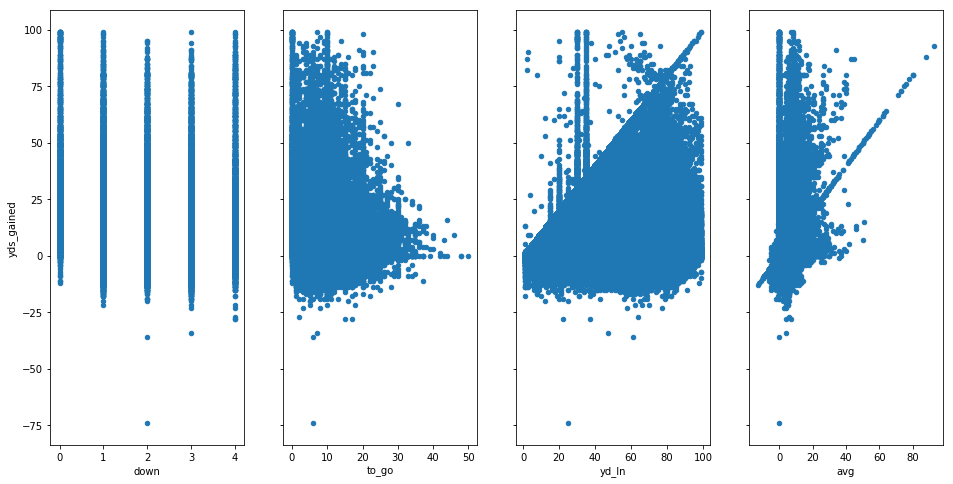

In [15]:
#Plot data
fig, axs = plt.subplots(1, 4, sharey = True)
df.plot(kind='scatter', x='down', y='yds_gained', ax=axs[0], figsize=(16, 8))
df.plot(kind='scatter', x='to_go', y='yds_gained', ax=axs[1], figsize=(16, 8))
df.plot(kind='scatter', x='yd_ln', y='yds_gained', ax=axs[2], figsize=(16, 8))
df.plot(kind='scatter', x='avg', y='yds_gained', ax=axs[3], figsize=(16, 8))

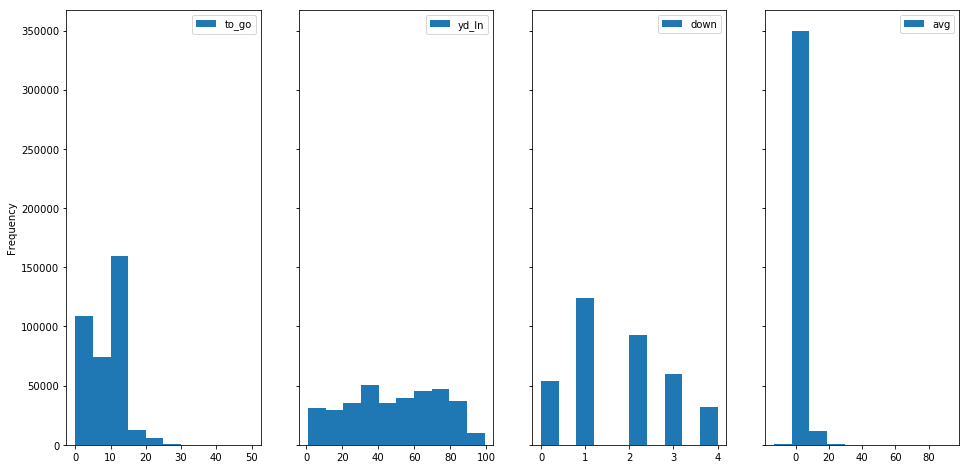

In [16]:
#Plot data
fig, axs = plt.subplots(1, 4, sharey = True)
df.plot(kind='hist', x='first', y='to_go', ax=axs[0], figsize=(16, 8))
df.plot(kind='hist', x='first', y='yd_ln', ax=axs[1], figsize=(16, 8))
df.plot(kind='hist', x='first', y='down', ax=axs[2], figsize=(16, 8))
df.plot(kind='hist', x='first', y='avg', ax=axs[3], figsize=(16, 8))

## Creating Data to Simulate Going for 1st on 4th

In [17]:
# sort into only 3rd down and possible play types
df_3rd = df.loc[df['down'] == 3]
df_3rd = df_3rd.loc[df['play_type'] <= 4]
df_3rd = df_3rd.loc[df['play_type'] != 3]
df_3rd.head(n=200)

,down,yd_ln,to_go,play_type,avg,yds_gained,first
3,3,56.0,8,1,0,0,0
7,3,94.0,6,2,0,-2,0
13,3,22.0,2,4,0,-19,0
19,3,19.0,7,1,7,0,0
23,3,70.0,7,4,-1,-9,0
29,3,57.0,3,1,7,8,1
34,3,76.0,7,1,0,0,0
40,3,34.0,12,4,4,-10,0
44,3,87.0,2,1,1,8,1
51,3,62.0,5,1,2,0,0


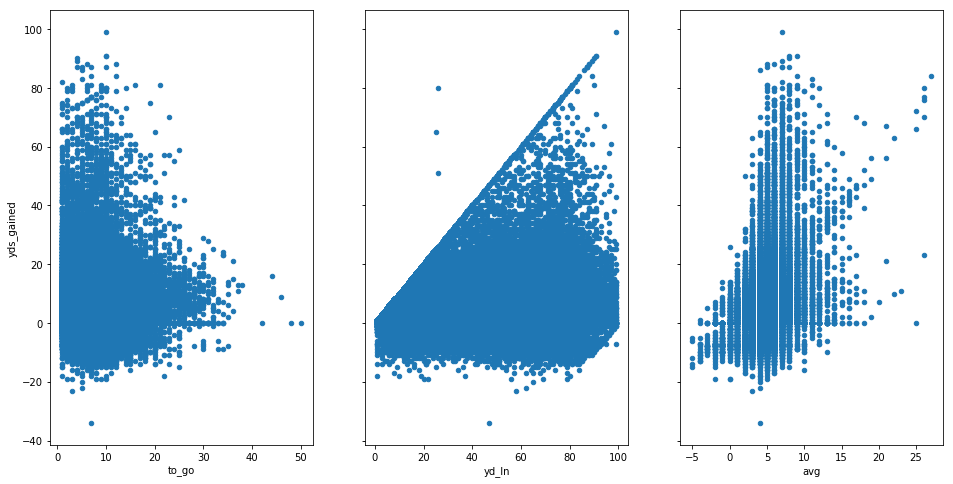

In [18]:
fig, axs = plt.subplots(1, 3, sharey =True)
df_3rd.plot(kind='scatter', x='to_go', y='yds_gained', ax=axs[0], figsize=(16, 8))
df_3rd.plot(kind='scatter', x='yd_ln', y='yds_gained', ax=axs[1], figsize=(16, 8))
df_3rd.plot(kind='scatter', x='avg', y='yds_gained', ax=axs[2], figsize=(16, 8))

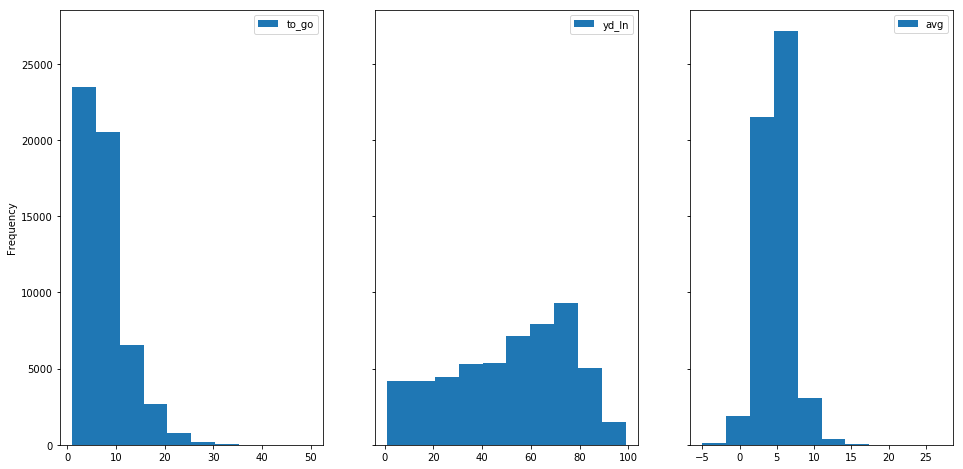

In [19]:
#Plot data
fig, axs = plt.subplots(1, 3, sharey = True)
df_3rd.plot(kind='hist', x='first', y='to_go', ax=axs[0], figsize=(16, 8))
df_3rd.plot(kind='hist', x='first', y='yd_ln', ax=axs[1], figsize=(16, 8))
df_3rd.plot(kind='hist', x='first', y='avg', ax=axs[2], figsize=(16, 8))

#  Models to predict going for a first down

In [20]:
df.corr()['yds_gained']

down         -0.025418
yd_ln         0.113545
to_go         0.046842
play_type    -0.290379
avg           0.210829
yds_gained    1.000000
first         0.481563
Name: yds_gained, dtype: float64

In [21]:
df_3rd.corr()['yds_gained']

down               NaN
yd_ln         0.109336
to_go         0.073815
play_type    -0.349948
avg           0.284788
yds_gained    1.000000
first         0.605343
Name: yds_gained, dtype: float64

In [22]:
df.corr()['first']

down         -0.280428
yd_ln        -0.203910
to_go        -0.505187
play_type     0.154080
avg          -0.108435
yds_gained    0.481563
first         1.000000
Name: first, dtype: float64

In [23]:
df_3rd.corr()['first']

down               NaN
yd_ln        -0.026169
to_go        -0.302554
play_type    -0.147272
avg           0.224278
yds_gained    0.605343
first         1.000000
Name: first, dtype: float64

In [24]:
lm = smf.ols(formula='yds_gained ~ to_go + yd_ln + down + avg', data=df).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             yds_gained   R-squared:                       0.058
Model:                            OLS   Adj. R-squared:                  0.058
Method:                 Least Squares   F-statistic:                     5581.
Date:                Wed, 22 Nov 2017   Prob (F-statistic):               0.00
Time:                        01:28:26   Log-Likelihood:            -1.3032e+06
No. Observations:              361724   AIC:                         2.606e+06
Df Residuals:                  361719   BIC:                         2.607e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.9714      0.039     50.387      0.000       1.895       2.048
to_go         -0.1059      0.003    -30.306      0.000      -0.113      -0.099
yd_ln          0.0443      0.001     69.032      0.000       0.043       0.046
down          -0.3902      0.013    -29.892      0.000      -0.416      -0.365
avg            0.6461      0.005    128.075      0.000       0.636       0.656
==============================================================================
Omnibus:                   234253.830   Durbin-Watson:                   2.076
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          3674312.917
Skew:                           2.912   Prob(JB):                         0.00
Kurtosis:                      17.487   Cond. No.                         148.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [25]:
lm.mse_resid, lm.mse_total

(78.873792287789428, 83.740587656521498)

In [26]:
lm = smf.ols(formula='first ~ to_go + down + yd_ln + avg', data=df).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  first   R-squared:                       0.283
Model:                            OLS   Adj. R-squared:                  0.283
Method:                 Least Squares   F-statistic:                 3.577e+04
Date:                Wed, 22 Nov 2017   Prob (F-statistic):               0.00
Time:                        01:28:27   Log-Likelihood:            -1.8987e+05
No. Observations:              361724   AIC:                         3.798e+05
Df Residuals:                  361719   BIC:                         3.798e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8054      0.002    446.979      0.000       0.802       0.809
to_go         -0.0481      0.000   -298.811      0.000      -0.048      -0.048
down          -0.0712      0.001   -118.458      0.000      -0.072      -0.070
yd_ln          0.0002   2.95e-05      7.869      0.000       0.000       0.000
avg            0.0077      0.000     33.050      0.000       0.007       0.008
==============================================================================
Omnibus:                    39831.566   Durbin-Watson:                   2.072
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            32795.679
Skew:                           0.652   Prob(JB):                         0.00
Kurtosis:                       2.309   Cond. No.                         148.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [27]:
lm.mse_resid, lm.mse_total

(0.16728524629220187, 0.23345963234871911)

In [28]:
lr = smf.logit(formula='first ~ to_go + down + yd_ln +  avg', data=df).fit()
lr.summary()

Optimization terminated successfully.
         Current function value: 0.483754
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  first   No. Observations:               361724
Model:                          Logit   Df Residuals:                   361719
Method:                           MLE   Df Model:                            4
Date:                Wed, 22 Nov 2017   Pseudo R-squ.:                  0.2667
Time:                        01:28:28   Log-Likelihood:            -1.7499e+05
converged:                       True   LL-Null:                   -2.3863e+05
                                        LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.8348      0.013    143.470      0.000       1.810       1.860
to_go         -0.3283      0.001   -252.456      0.000      -0.331      -0.326
down          -0.4847      0.004   -121.231      0.000      -0.493      -0.477
yd_ln          0.0056      0.000     31.282      0.000       0.005       0.006
avg            0.1016      0.002     65.400      0.000       0.099       0.105
==============================================================================
"""

In [29]:
lr = smf.logit(formula='first ~ avg + to_go + yd_ln', data=df).fit()
lr.summary()

Optimization terminated successfully.
         Current function value: 0.506487
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  first   No. Observations:               361724
Model:                          Logit   Df Residuals:                   361720
Method:                           MLE   Df Model:                            3
Date:                Wed, 22 Nov 2017   Pseudo R-squ.:                  0.2322
Time:                        01:28:29   Log-Likelihood:            -1.8321e+05
converged:                       True   LL-Null:                   -2.3863e+05
                                        LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1408      0.010    116.982      0.000       1.122       1.160
avg            0.0898      0.001     60.534      0.000       0.087       0.093
to_go         -0.3175      0.001   -258.242      0.000      -0.320      -0.315
yd_ln          0.0022      0.000     12.589      0.000       0.002       0.003
==============================================================================
"""

In [30]:
df.replace([np.inf, -np.inf], np.nan)
df.dropna()
df.astype(np.float32)

train = df.sample(frac=0.8, random_state=1)
test = df.loc[~df.index.isin(train.index)]
columns = ['down', 'to_go', 'avg']
print(train.shape)
print(test.shape)

(289958, 7)
(72489, 7)


In [31]:
df['yd_ln'].astype(np.float32)

0         30.0
1         58.0
2         53.0
3         56.0
4         56.0
5         98.0
6         98.0
7         94.0
8         96.0
9         43.0
10        40.0
11        30.0
12        31.0
13        22.0
14        41.0
15        89.0
16        42.0
17        22.0
18        19.0
19        19.0
20        19.0
21        73.0
22        72.0
23        70.0
24        79.0
25        74.0
26        64.0
27        69.0
28        60.0
29        57.0
          ... 
362417    34.0
362418    25.0
362419    25.0
362420    21.0
362421    21.0
362422    16.0
362423    16.0
362424     9.0
362425     2.0
362426    35.0
362427    75.0
362428    75.0
362429    64.0
362430    45.0
362431    45.0
362432    21.0
362433    21.0
362434    15.0
362435    80.0
362436    20.0
362437    80.0
362438    20.0
362439    81.0
362440    19.0
362441    83.0
362442    35.0
362443    15.0
362444    35.0
362445    46.0
362446    46.0
Name: yd_ln, Length: 362447, dtype: float32

In [32]:
target = 'yds_gained'
model = RandomForestRegressor()
model.fit(train[columns], train[target])
predictions = model.predict(test[columns])
mean_squared_error(predictions, test[target])

77.96250459916395

In [33]:
predictions

array([ 4.89632912,  1.59169736,  1.52422376, ...,  3.98212072,
        6.52449819,  4.89632912])

In [34]:
actual = [x for x in test['yds_gained']]
diff = []
for x in range(len(actual)):
    d = actual[x] - predictions[x]
    diff.append(d)
print sum(diff)/len(diff)

-0.0110881327624


In [35]:
target = 'first'
model = RandomForestRegressor()
model.fit(train[columns], train[target])
predictions = model.predict(test[columns])
mean_squared_error(predictions, test[target])

0.14145250895515538

In [36]:
predictions

array([ 0.99954276,  0.06452984,  0.12453403, ...,  0.10777683,
        0.22977409,  0.99954276])

In [37]:
actual = [x for x in test['first']]
diff = []
for x in range(len(actual)):
    d = actual[x] - predictions[x]
    diff.append(abs(d))
print sum(diff)/len(diff)

0.282343523982


## Analyzing Data for Field Goals 

In [38]:
fg = f.loc[f['PlayType'] == "Field Goal"]
fg['FieldGoalResult']

20        No Good
65        Blocked
131          Good
146          Good
177          Good
186          Good
208          Good
230          Good
314          Good
375          Good
450       Blocked
474          Good
482          Good
542          Good
553       Blocked
560          Good
615       No Good
737          Good
910          Good
935          Good
943       No Good
982       No Good
1104         Good
1140         Good
1220         Good
1269         Good
1342      Blocked
1384         Good
1440      No Good
1500         Good
           ...   
361031       Good
361086       Good
361112       Good
361134    No Good
361222       Good
361233       Good
361296       Good
361346       Good
361358       Good
361394       Good
361433       Good
361458       Good
361468       Good
361479       Good
361602       Good
361689    No Good
361749       Good
361804    No Good
361837       Good
361873       Good
361896       Good
361940       Good
361999       Good
362025       Good
362090    

In [39]:
fg_result = []
a = [x for x in fg["FieldGoalResult"]]
for x in range(fg.shape[0]):
    if a[x] == "Good":
        fg_result.append(1)
    else:
        fg_result.append(0)
print fg_result

[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 

b = [x for x in fg['FieldGoalDistance']]
df_fg = {
    'distance': pd.Series(b),
    'result': pd.Series(fg_result)
}

df_fg = pd.DataFrame(df_fg, columns=[
    'distance', 'result'
])
df_fg

In [40]:
yrd_ln = a = [x for x in fg["yrdline100"]]

In [41]:
df_fg = {
    'yd_ln': pd.Series(yrd_ln),
    'result': pd.Series(fg_result)
}
df_fg = pd.DataFrame(df_fg, columns=[
    'yd_ln', 'result'
])
df_fg.head(n=10)

,yd_ln,result
0,19.0,0
1,13.0,0
2,27.0,1
3,14.0,1
4,15.0,1
5,20.0,1
6,3.0,1
7,2.0,1
8,20.0,1
9,29.0,1


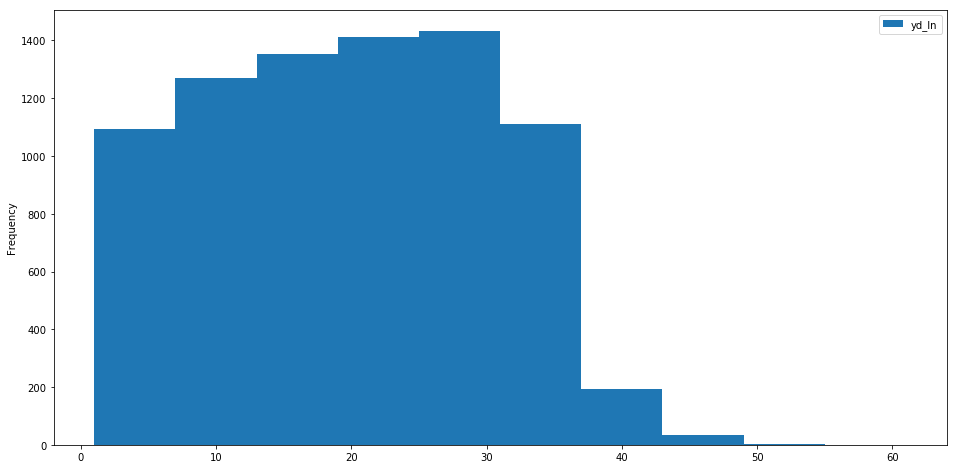

In [42]:
df_fg.plot(kind='hist', x='result', y='yd_ln', figsize=(16, 8))

In [43]:
train = df_fg.sample(frac=0.8, random_state=1)
test = df_fg.loc[~df_fg.index.isin(train.index)]
columns = ['yd_ln']
print(train.shape)
print(test.shape)

(6322, 2)
(1580, 2)


In [44]:
target = 'result'
model = RandomForestRegressor()
model.fit(train[columns], train[target])
predictions = model.predict(test[columns])
mean_squared_error(predictions, test[target])

0.11565212363474604

## Predicting Punt Distance 

In [45]:
punt_dist = []
for x in range(df.shape[0]):
    if f['PlayType'][x] == 'Punt':
        a = f['yrdline100'][x]
        b = 100 - f['yrdline100'][x+1]
        c = a - b
        punt_dist.append(c)
    else:
        punt_dist.append(0)

In [46]:
yd_ln = []
distance = []
for x in range(len(punt_dist)):
    if punt_dist[x] > 0:
        yd_ln.append(f['yrdline100'][x])
        distance.append(punt_dist[x])

In [47]:
df_punt = {
    'yd_ln': pd.Series(yd_ln),
    'distance': pd.Series(distance)
}
df_punt = pd.DataFrame(df_punt, columns = [
    'yd_ln', 'distance'
])
df_punt.head(n=20)

,yd_ln,distance
0,56.0,54.0
1,96.0,39.0
2,41.0,30.0
3,79.0,53.0
4,44.0,39.0
5,62.0,35.0
6,45.0,40.0
7,96.0,50.0
8,43.0,33.0
9,71.0,56.0


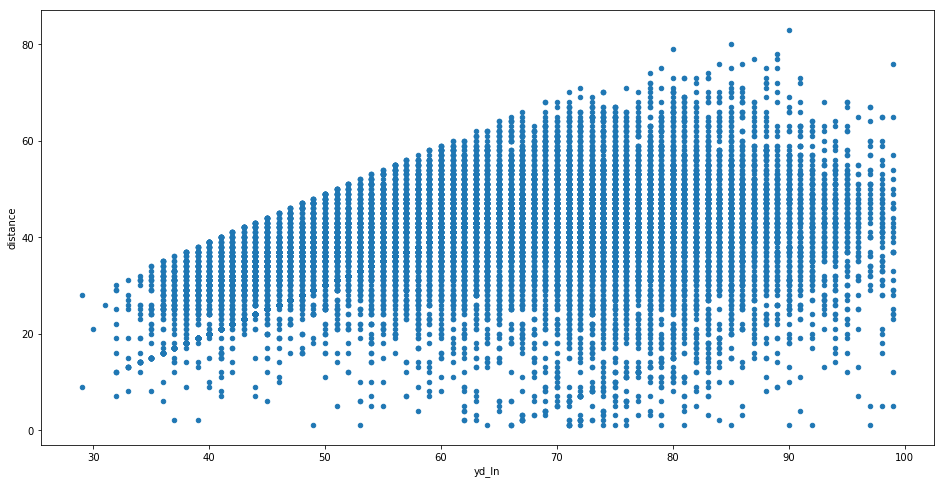

In [48]:
df_punt.plot(kind='scatter', x='yd_ln', y='distance', figsize=(16, 8))

In [49]:
train = df_punt.sample(frac=0.8, random_state=1)
test = df_punt.loc[~df_punt.index.isin(train.index)]
columns = ['yd_ln']
print(train.shape)
print(test.shape)

(15378, 2)
(3844, 2)


In [50]:
target = 'distance'
model = RandomForestRegressor()
model.fit(train[columns], train[target])
predictions = model.predict(test[columns])
mean_squared_error(predictions, test[target])

96.99008154822026

In [51]:
predictions

array([ 31.2133589 ,  43.13378679,  42.6315135 , ...,  42.02481621,
        42.72155196,  41.82177924])

In [52]:
actual = [x for x in test['distance']]
diff = []
for x in range(len(actual)):
    d = actual[x] - predictions[x]
    diff.append(abs(d))
print sum(diff)/len(diff)

7.4087781766
